# Testing aerobulk-python performance

In the following notebook I will investigate:
1. How the computation time scales with the number of time iterations.
2. How the order of dimensions (e.g. longest to shortest or vice versa) influences the exection time of aerobulk python
3. How the execution time scales with values of `niter`
<!-- 4. How the skin correction influences execution time.
5. What is the lowest value of `niter` that provides sufficiently converged values of surface fluxes.
 -->

All test will be carried out with the numpy wrapper, and not involve dask at all.

I developed this on the large pangeo deployment (32GB? Ram and 8 cores).

In [1]:
# You need to run this each time when your notebook server was closed (e.g. when you logged out)
# !mamba install aerobulk-python -y

In [2]:
# Check version
import aerobulk
print(aerobulk.__version__)

0.2.3


In [3]:
import time
import xarray as xr
from aerobulk import flux_noskin
import itertools
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [80]:
# A function to generate test data for 1./2./3. 
# In the future we can just import this from aerobulk-python, 
# when this is merged:https://github.com/xgcm/aerobulk-python/pull/15/files
import numpy as np
from typing import Dict
def create_data(shape: tuple, chunks: Dict[str, int] = {}):
    def _arr(value):
        order = "F"  # Does this matter for the results?
        # order = None
        arr = xr.DataArray(np.full(shape, value, order=order))

        # adds random noise scaled by a percentage of the value
        randomize_factor = 0.001
        randomize_range = value * randomize_factor
        arr = arr + np.random.rand(*shape) + randomize_range

        if chunks:
            arr = arr.chunk(chunks)
        return arr

    sst = _arr(290.0)
    t_zt = _arr(280.0)
    hum_zt = _arr(0.001)
    u_zu = _arr(1.0)
    v_zu = _arr(-1.0)
    slp = _arr(101000.0)
    return sst, t_zt, hum_zt, u_zu, v_zu, slp

## 0. Execution time based on length of iterdimension

In [81]:
nt_list = np.array([1,2,3,5, 10, 25, 50])

time_list = []
time_std_list = []
for nt in nt_list:
    shape = (300, 150, nt)
    time_sub = []
    for repeat in range(1): # there was really no deviation between these
        test_data = create_data(shape)
        tic = time.time()
        flux_noskin(*test_data, niter=1)
        toc = time.time() - tic
        time_sub.append(toc)
    time_sub = np.array(time_sub)
    time_average = np.mean(time_sub)
    time_std = np.std(time_sub)
    
    time_list.append(time_average)
    time_std_list.append(time_std)

def _relative(in_list, ref):
    return [a/ref for a in in_list]

relative_execution_time = np.array(_relative(time_list, time_list[0]))
relative_execution_std = np.array(_relative(time_std_list, time_list[0]))
time_length = np.array(nt_list)

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00300 x 00150
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `relative humidity [%]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00300 x 00150
     *** Number of time records that will be treated:           2
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of pr

Text(0.5, 1.0, "Scaling of compute time for changing time iterations\nwith (300, 150, 'time') array")

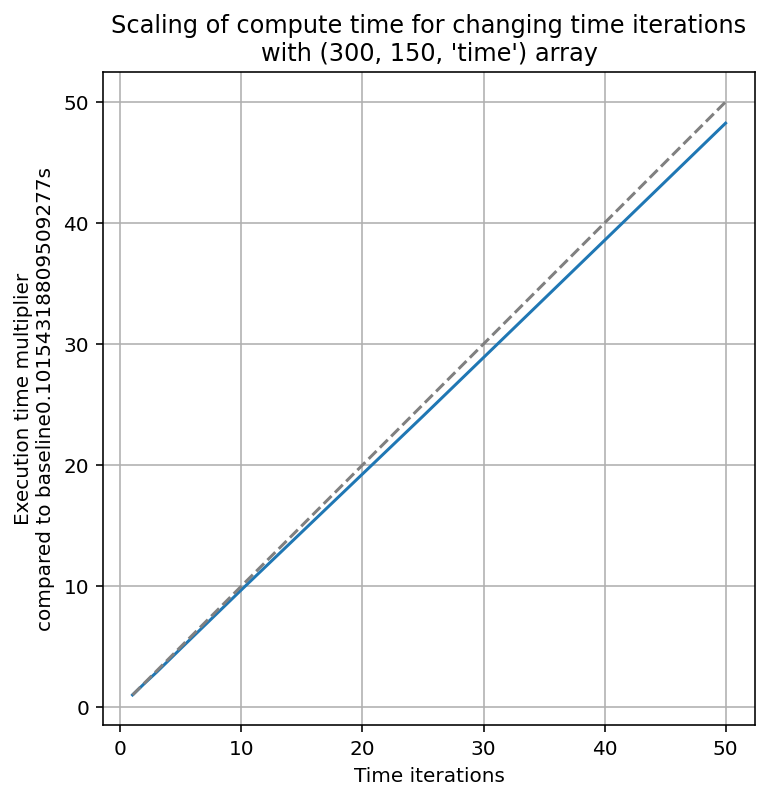

In [82]:
plt.plot(time_length, relative_execution_time)
plt.plot(time_length, time_length, color='0.5', ls='--')
plt.ylabel(f'Execution time multiplier\ncompared to baseline{time_list[0]}s')
plt.xlabel(f'Time iterations')
plt.grid()
plt.gca().set_aspect(1)
plt.title(f"Scaling of compute time for changing time iterations\nwith {(shape[0], shape[1], 'time')} array")

- There seems to be almost no overhead for the init! This is good news for our chunking structure!
- Slightly lower slope than 1, meaning that there is a slight advantage for processing larger chunks, but not much.

## 1. Execution time based on input shape

In [83]:
shape_list = list(itertools.permutations((10000, 100, 1)))+list(itertools.permutations((1000, 1000, 1)))

time_list = []
time_std_list = []
for shape in shape_list:
    time_sub = []
    for repeat in range(10):
        test_data = create_data(shape)
        tic = time.time()
        flux_noskin(*test_data, niter=1)
        toc = time.time() - tic
        time_sub.append(toc)
    time_sub = np.array(time_sub)
    time_average = np.mean(time_sub)
    time_std = np.std(time_sub)
    
    time_list.append(time_average)
    time_std_list.append(time_std)
    

# sort by execution time
time_list_sorted, time_std_list_sorted, shape_list_sorted = zip(*sorted(zip(time_list, time_std_list, shape_list)))

#normalize execution time
tmin = min(time_list)
normalized_time = [(t-tmin)/tmin for t in time_list_sorted]
normalized_std = [t/tmin for t in time_std_list_sorted]

normalized_std = np.array(normalized_std)
normalized_time = np.array(normalized_time)

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 10000 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `relative humidity [%]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 10000 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of pr

Yeah those print statments are quite annoying...😤. We should work on https://github.com/xgcm/aerobulk-python/issues/24

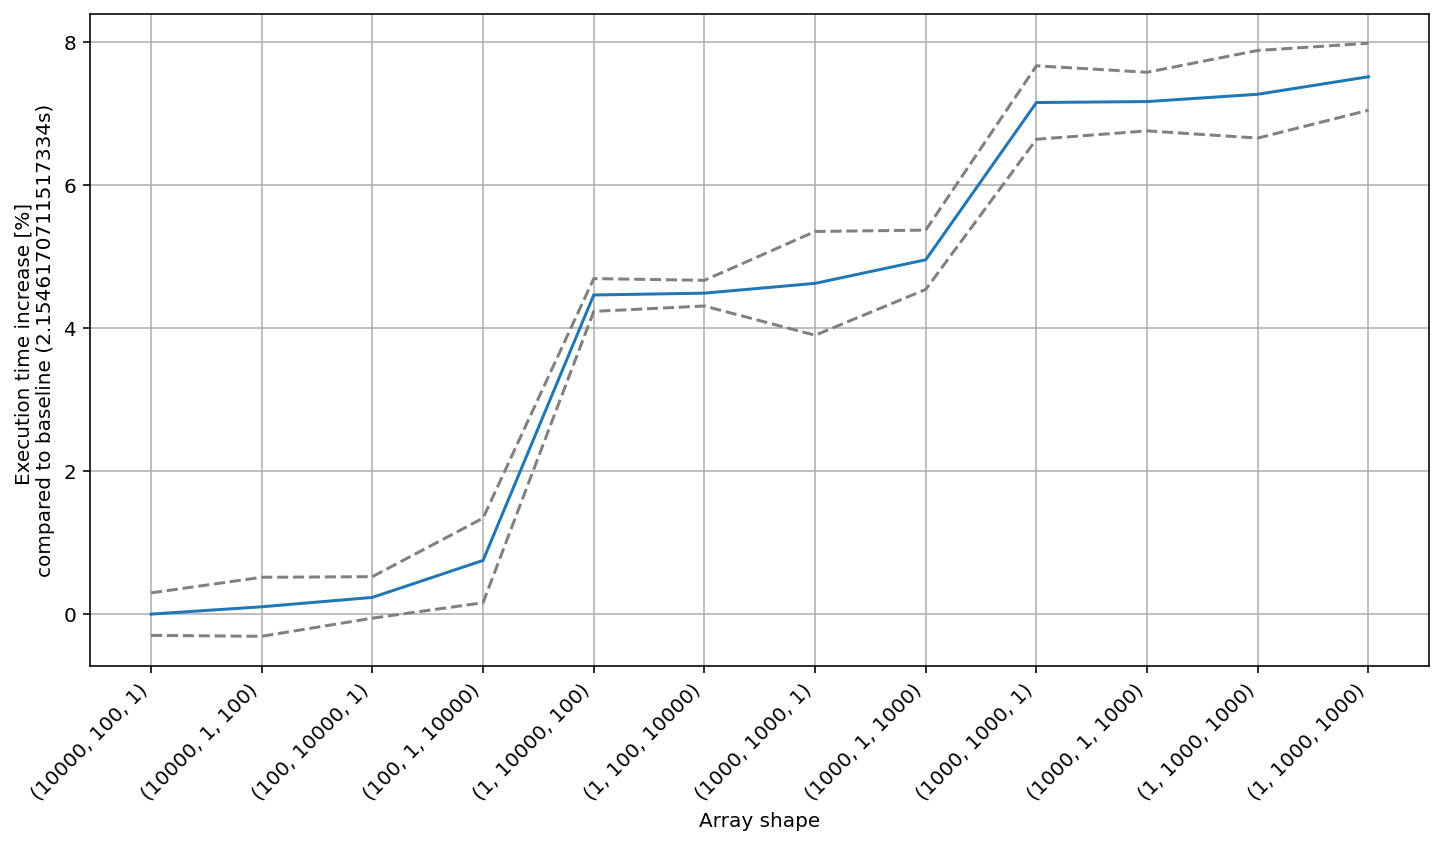

In [84]:
plt.plot(normalized_time*100)
plt.plot((normalized_time+normalized_std)*100, ls='--', color='0.5')
plt.plot((normalized_time-normalized_std)*100, ls='--', color='0.5')
plt.ylabel(f'Execution time increase [%] \ncompared to baseline ({tmin}s)')
plt.xticks(ticks = range(len(normalized_time)), labels=shape_list, ha='right', rotation=45)
plt.xlabel('Array shape')
plt.grid()

**Conclusions**
- I do not really understand these results TBH. I would have expected all shapes that have the smallest number last to be fastest.
- It seems to matter more if the x/y shape is elongated vs square
- Overall it seems like the shape does not matter that much (few percent of execution time). Certainly not something we have to worry about as a immediate priority. 

## How does the execution time scales with values of `niter`

In [95]:
niter_list = np.arange(1,20)
shape = (700, 100, 1)

time_list = []
time_std_list = []
for niter in niter_list:
    time_sub = []
    for repeat in range(1): # there was really no deviation between these
        test_data = create_data(shape)
        tic = time.time()
        flux_noskin(*test_data, niter=niter)
        toc = time.time() - tic
        time_sub.append(toc)
    time_sub = np.array(time_sub)
    time_average = np.mean(time_sub)
    time_std = np.std(time_sub)
    
    time_list.append(time_average)
    time_std_list.append(time_std)

def _relative(in_list, ref):
    return [a/ref for a in in_list]


relative_execution_time = np.array(_relative(time_list, time_list[0]))
relative_execution_std = np.array(_relative(time_std_list, time_list[0]))
iteration_length = np.array(niter_list)

 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00700 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    1
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of prescribed air humidity  `relative humidity [%]`
                    ----- AeroBulk_bye -----
 
 
                    ----- AeroBulk_init -----
 
     *** Bulk parameterization to be used => "coare3p0"
     *** Cool-skin & Warm-layer schemes will NOT be used!
     *** Computational domain shape: Ni x Nj = 00700 x 00100
     *** Number of time records that will be treated:           1
     *** Number of iterations in bulk algos: nb_iter  =    2
     *** Filling the `mask` array...
         ==> no points need to be masked! :)
     *** Type of pr

Text(0.5, 1.0, 'Scaling of compute time for changing algorithm iterations\nwith (700, 100, 1) array')

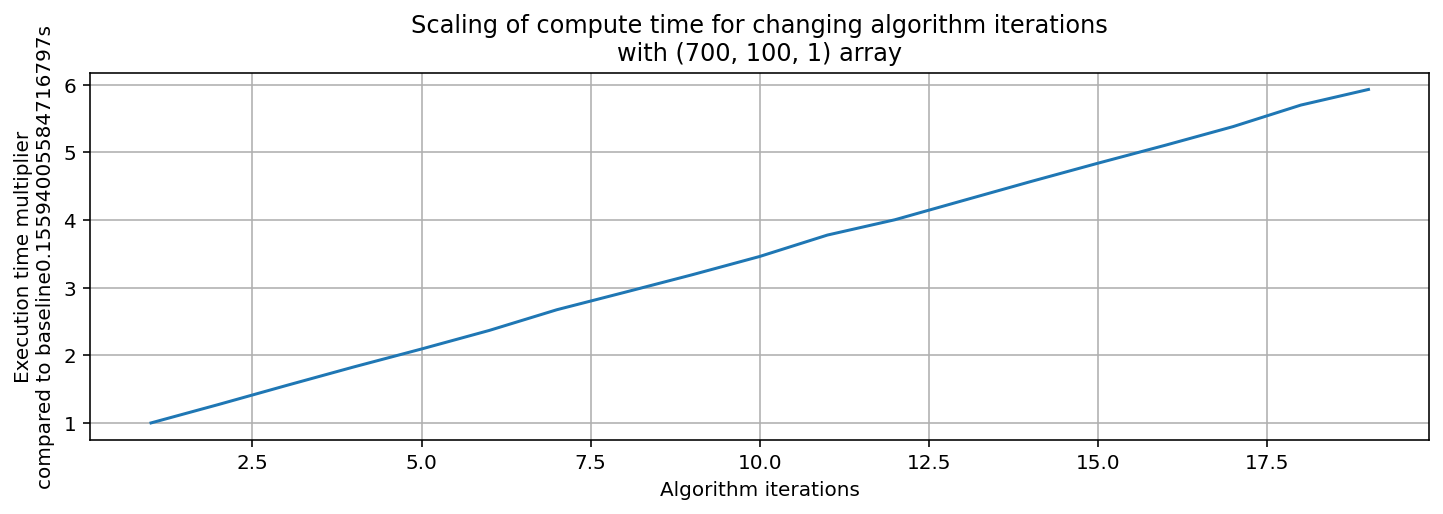

In [96]:
plt.plot(iteration_length, relative_execution_time)
# plt.plot(iteration_length, iteration_length, color='0.5', ls='--')
plt.ylabel(f'Execution time multiplier\ncompared to baseline{time_list[0]}s')
plt.xlabel(f'Algorithm iterations')
plt.grid()
plt.gca().set_aspect(1)
plt.title(f"Scaling of compute time for changing algorithm iterations\nwith {(shape[0], shape[1], shape[2])} array")